In [133]:
# Import Library
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from keras.preprocessing.image import ImageDataGenerator #, img_to_array, 
from tensorflow.keras.utils import img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
import os
import pickle
import warnings
warnings.filterwarnings("ignore")
from PIL import Image

# Prepare and Review Dataset

In [134]:
# Test and Train path
with open('newResa3.pickle', 'rb') as handle:
    newResa3 = pickle.load(handle)

with open('AllPixelBand3.pickle', 'rb') as handle:
    allPixel3 = pickle.load(handle)

# Identificare qualita' e suddivisione del dataset in maniera corretta tra train e test

 Resa bassa: 58 Resa media[4500,10000]: 1472 Resa alta(>10000): 31


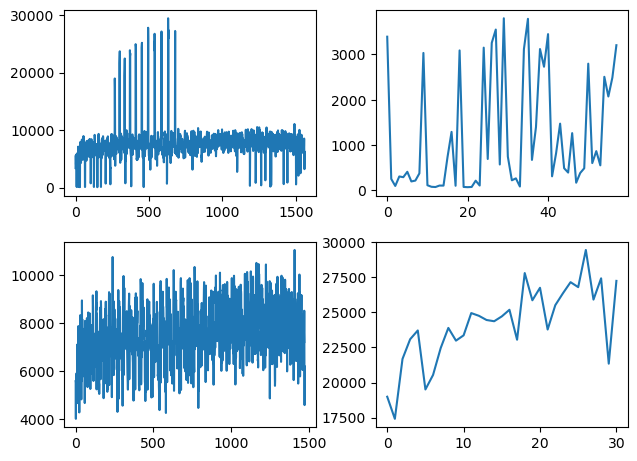

In [135]:
#taglio outliar
FilterResa3gtZero = newResa3!=0
newResa3 = newResa3[FilterResa3gtZero]
allPixel3 = allPixel3[FilterResa3gtZero,:,:]

LowValue = 1
Medium = 4000
HighValue = 12000
Resa3LowFilter = (newResa3<Medium) & (newResa3>LowValue)
Resa3MediumFilter = (newResa3>=Medium) & (newResa3<=HighValue)
Resa3HighFilter = (newResa3>HighValue)

Resa3Low = newResa3[Resa3LowFilter]
Resa3Medium = newResa3[Resa3MediumFilter]
Resa3High = newResa3[Resa3HighFilter]

Pixel3Low = allPixel3[Resa3LowFilter,:,:]
Pixel3Medium = allPixel3[Resa3MediumFilter,:,:]
Pixel3High = allPixel3[Resa3HighFilter,:,:]


print(" Resa bassa: "+str(len(Resa3Low))+ " Resa media[4500,10000]: "+ str(len(Resa3Medium))+ " Resa alta(>10000): "+ str(len(Resa3High)))

padding = 1.2
f, axarr = plt.subplots(2,2)
f.tight_layout(pad=padding)
axarr[0][0].plot(newResa3)
axarr[0][1].plot(Resa3Low)
axarr[1][0].plot(Resa3Medium)
axarr[1][1].plot(Resa3High)
plt.show()

In [136]:
# Normalizziamo le rese

Resa3Medium = Resa3Medium/Resa3Medium.max()

In [137]:
# Funzione per lo split

def splitSet(X,Y):
    if X.shape[0] != Y.shape[0]:
        raise Exception("X and Y have different sizes")
    choice = np.random.choice(range(X.shape[0]), size=(int(X.shape[0]/2),), replace=False)
    ind = np.zeros(X.shape[0], dtype=bool)
    ind[choice] = True
    rest = ~ind
    return np.array(X[ind,:,:]),np.array(Y[ind]),np.array(X[rest,:,:]),np.array(Y[rest])

In [138]:
print(Resa3Medium.mean())

0.6914101


# Andiamo a costruire le immagini

[0.71325016 0.64559835 0.47243312 0.4654555  0.5474331  0.7135485
 0.7541757  0.67381597 0.68512297 0.56777835]


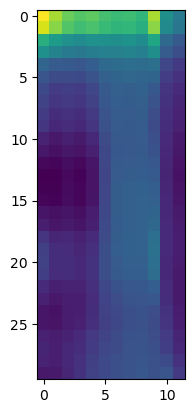

In [156]:
# Test and Train path
train_path = "dataset2\\train\\"
test_path = "dataset2\\test\\"

#training_setLowX, training_setLowY, test_setLowX, test_setLowY = splitSet(Pixel3Low,Resa3Low)
training_setMediumX,training_setMediumY, test_setMediumX, test_setMediumY = splitSet(Pixel3Medium,Resa3Medium)
#training_setHighX,training_setHighY, test_setHighX, test_setHighY = splitSet(Pixel3High,Resa3High)

#training_setX = np.concatenate([training_setLowX,training_setMediumX,training_setHighX],axis=0)
#training_setY = np.concatenate([training_setLowY,training_setMediumY,training_setHighY],axis=0)
training_setX = training_setMediumX
training_setY = training_setMediumY

#test_setX = np.concatenate([test_setLowX,test_setMediumX,test_setHighX],axis=0)
#test_setY = np.concatenate([test_setLowY,test_setMediumY,test_setHighY],axis=0)
test_setX = test_setMediumX
test_setY = test_setMediumY

print(training_setY[10:20])
plt.imshow(np.transpose(training_setX[0,:,:]))

# Per il professore
for a in range(0,Pixel3Medium.shape[0]):
    if Resa3Medium[a] == Resa3Medium.max():
        img = Image.fromarray(Pixel3Medium[a,:,:])
        img.save("dataset2\\max\\"+str(a)+'.tiff')
    if Resa3Medium[a] == Resa3Medium.min():
        img = Image.fromarray(Pixel3Medium[a,:,:])
        img.save("dataset2\\min\\"+str(a)+'.tiff')

#Train Set
for a in range(0,training_setX.shape[0]):
    if training_setY[a] < Resa3Medium.mean():
        img = Image.fromarray(training_setX[a,:,:])
        img.save(train_path+"0\\"+str(a)+'.tiff')
    else:
        img = Image.fromarray(training_setX[a,:,:])
        img.save(train_path+"1\\"+str(a)+'.tiff')

#Test Set
for a in range(0,test_setX.shape[0]):
    if test_setY[a] < Resa3Medium.mean():
        img = Image.fromarray(test_setX[a,:,:])
        img.save(test_path+"0\\"+str(a)+'.tiff')
    else:
        img = Image.fromarray(test_setX[a,:,:])
        img.save(test_path+"1\\"+str(a)+'.tiff')

In [140]:
print(training_setY.mean())

0.6929279


In [141]:
# Test and Train path
train_path = "dataset2\\train"
test_path = "dataset2\\test"

# The number of classes of dataset
numberOfClass = len(glob(train_path + "/*"))
print("Number Of Class: ", numberOfClass)

# Prepare the datasef for vgg16
train_data = ImageDataGenerator().flow_from_directory(train_path, target_size = (32,32))
print(type(train_data))
test_data = ImageDataGenerator().flow_from_directory(test_path, target_size = (32,32))

Number Of Class:  2
Found 736 images belonging to 2 classes.
<class 'keras.preprocessing.image.DirectoryIterator'>
Found 736 images belonging to 2 classes.


# Creazione del modello di Vgg16

In [142]:
# Import model
#vgg16 = VGG16(input_shape=(allPixel3.shape[1],allPixel3.shape[2],3),include_top=False)

# Import model
vgg16 = VGG16(input_shape=(32,32,3),include_top=False)

In [143]:
# Layers of vgg16 
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [144]:
# layers of vgg16
vgg16_layer_list = vgg16.layers
for i in vgg16_layer_list:
    print(i)

In [145]:
# add the layers of vgg16 in my created model.
vgg16Model = Sequential()
for i in range(len(vgg16_layer_list)):
    vgg16Model.add(vgg16_layer_list[i])

In [146]:
# Close the layers of vgg16
'''for layers in vgg16Model.layers:
    layers.trainable = False'''

'for layers in vgg16Model.layers:\n    layers.trainable = False'

In [147]:
# Last layer
#vgg16Model.add(Dense(units=1))
vgg16Model.add(Flatten())
vgg16Model.add(Dense(512, activation = "relu"))
vgg16Model.add(Dense(512, activation = "relu"))
vgg16Model.add(Dense(512, activation = "relu"))
vgg16Model.add(Dense(512, activation = "relu"))
vgg16Model.add(Dense(numberOfClass, activation = "softmax"))

In [148]:
# After I added last layer in created model.
vgg16Model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)       (None, 8, 8, 256)        

In [149]:
# I create compile part.
vgg16Model.compile(loss = "categorical_crossentropy",
             optimizer = "adam",
             metrics = ["accuracy"])

# Training Model 

In [150]:
# Traning with model
batch_size = 32

hist_vgg16 = vgg16Model.fit(train_data, 
                                epochs = 30, 
                                validation_data = test_data
                                )

Epoch 1/30
23/23 [==============================] - 26s 1s/step - loss: 1.5749 - accuracy: 0.4783 - val_loss: 0.7040 - val_accuracy: 0.4918
Epoch 2/30
23/23 [==============================] - 20s 862ms/step - loss: 0.7006 - accuracy: 0.4905 - val_loss: 0.6950 - val_accuracy: 0.5082
Epoch 3/30
23/23 [==============================] - 19s 834ms/step - loss: 0.6968 - accuracy: 0.5095 - val_loss: 0.6979 - val_accuracy: 0.5082
Epoch 4/30
23/23 [==============================] - 19s 833ms/step - loss: 0.7019 - accuracy: 0.4878 - val_loss: 0.6930 - val_accuracy: 0.5082
Epoch 5/30
23/23 [==============================] - 20s 889ms/step - loss: 0.6934 - accuracy: 0.5258 - val_loss: 0.6930 - val_accuracy: 0.5082
Epoch 6/30
23/23 [==============================] - 20s 852ms/step - loss: 0.6936 - accuracy: 0.4959 - val_loss: 0.6930 - val_accuracy: 0.5082
Epoch 7/30
23/23 [==============================] - 19s 842ms/step - loss: 0.6934 - accuracy: 0.5258 - val_loss: 0.6939 - val_accuracy: 0.5082
Ep

In [ ]:
# Save the weights of model
vgg16Model.save_weights("deneme.h5")

# Andiamo a visualizzare i risultati della rete

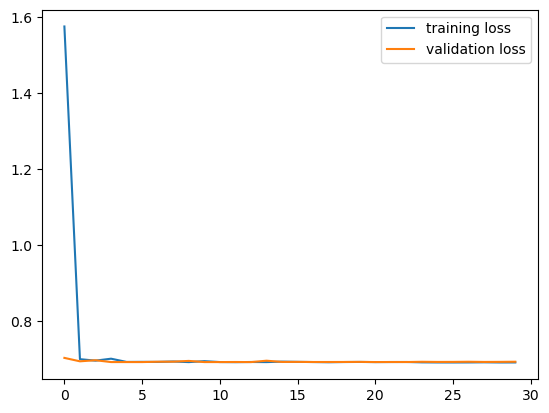

In [151]:
# Loss and Validation Loss
plt.plot(hist_vgg16.history["loss"], label = "training loss")
plt.plot(hist_vgg16.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

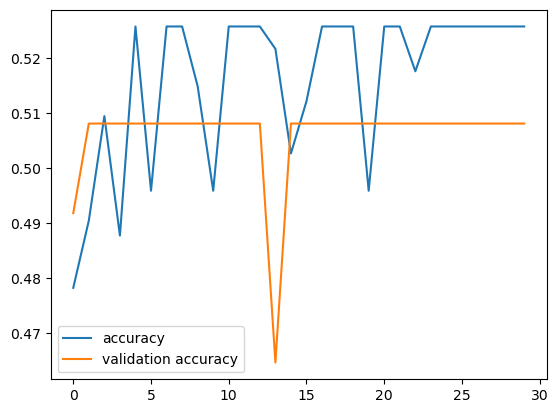

In [152]:
# Accuracy and Validation Accuracy
plt.plot(hist_vgg16.history["accuracy"], label = "accuracy")
plt.plot(hist_vgg16.history["val_accuracy"], label = "validation accuracy")
plt.legend()
plt.show()

# Salviamo e carichiamo i risultati

In [ ]:
import json, codecs
with open("deneme.json","w") as f:
    json.dump(hist_vgg16.history, f)

In [ ]:
with codecs.open("./deneme.json","r", encoding = "utf-8") as f:
    load_result = json.loads(f.read())

In [ ]:
load_result

{'loss': [0.7054945230484009,
  0.5136629343032837,
  0.3976057469844818,
  0.4307115972042084,
  0.3863684833049774,
  0.3716677725315094,
  0.40057018399238586,
  0.3416111469268799,
  0.40405699610710144,
  0.28724029660224915],
 'accuracy': [0.7649999856948853,
  0.828125,
  0.8637499809265137,
  0.8662499785423279,
  0.8799999952316284,
  0.8837500214576721,
  0.8650000095367432,
  0.8962500095367432,
  0.8731250166893005,
  0.9043750166893005],
 'val_loss': [0.5836769342422485,
  0.3789961338043213,
  0.37915927171707153,
  0.38540345430374146,
  0.42800384759902954,
  0.3940734565258026,
  0.39924734830856323,
  0.41608214378356934,
  0.3162184953689575,
  0.40526703000068665],
 'val_accuracy': [0.7749999761581421,
  0.8575000166893005,
  0.875,
  0.8725000023841858,
  0.8637499809265137,
  0.8725000023841858,
  0.8799999952316284,
  0.8587499856948853,
  0.9012500047683716,
  0.8799999952316284]}

In [ ]:
# Loss And Validation Loss
plt.plot(load_result["loss"], label = "training loss")
plt.plot(load_result["val_loss"], label = "validation loss")
plt.legend()
plt.show()

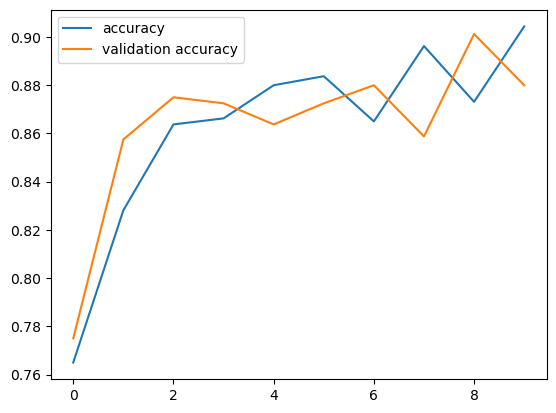

In [ ]:
plt.plot(load_result["accuracy"], label = "accuracy")
plt.plot(load_result["val_accuracy"], label = "validation accuracy")
plt.legend()
plt.show()

# Predizione della classe

In [153]:
predict_path = "dataset2\\predict\\"

predict_data = ImageDataGenerator().flow_from_directory(directory=predict_path,target_size=(32,32))
                                                 
prediction = vgg16Model.predict(predict_data)
print(prediction)   

Found 4 images belonging to 1 classes.
1/1 [==============================] - 0s 182ms/step
[[0.47079277 0.5292072 ]
 [0.47079355 0.52920645]
 [0.47079277 0.5292072 ]
 [0.47079352 0.52920645]]


# Vgg19

In [ ]:
# Import VGG19 model
vgg19 = VGG19()

574710816/574710816 [==============================] - 114s 0us/step


In [ ]:
# Layers of vgg19
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Layers of vgg19 
vgg19_layer_list = vgg19.layers
for i in vgg19_layer_list:
    print(i)

In [ ]:
# add the layers of vgg16 in my created model.
vgg19Model = Sequential()
for i in range(len(vgg19_layer_list)-1):
    vgg19Model.add(vgg19_layer_list[i])

In [ ]:
# Finish version of my created model.
vgg19Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [ ]:
# Close the layers of vgg16
for layers in vgg19Model.layers:
    layers.trainable = False

In [ ]:
# Last layer
vgg19Model.add(Dense(numberOfClass, activation = "softmax"))

In [ ]:
# the final version of the model
vgg19Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [ ]:
# I create compile part.
vgg19Model.compile(loss = "categorical_crossentropy",
             optimizer = "rmsprop",
             metrics = ["accuracy"])

# Addestramento

In [ ]:
# Traning with model
batch_size = 32

# Training with my created model
hisy_vgg19 = vgg19Model.fit_generator(train_data,
                               steps_per_epoch = 1600 // batch_size,
                               epochs = 10,
                               validation_data = test_data,
                               validation_steps = 800 // batch_size)

Epoch 1/10
50/50 [==============================] - 700s 14s/step - loss: 0.6683 - accuracy: 0.7713 - val_loss: 0.4304 - val_accuracy: 0.8600
Epoch 2/10
50/50 [==============================] - 622s 12s/step - loss: 0.4122 - accuracy: 0.8581 - val_loss: 0.4579 - val_accuracy: 0.8550
Epoch 3/10
50/50 [==============================] - 313s 6s/step - loss: 0.4227 - accuracy: 0.8588 - val_loss: 0.4613 - val_accuracy: 0.8462
Epoch 4/10
50/50 [==============================] - 317s 6s/step - loss: 0.3969 - accuracy: 0.8744 - val_loss: 0.4060 - val_accuracy: 0.8687
Epoch 5/10
50/50 [==============================] - 395s 8s/step - loss: 0.3667 - accuracy: 0.8856 - val_loss: 0.5224 - val_accuracy: 0.8388
Epoch 6/10
50/50 [==============================] - 319s 6s/step - loss: 0.3512 - accuracy: 0.8794 - val_loss: 0.4440 - val_accuracy: 0.8625
Epoch 7/10
50/50 [==============================] - 318s 6s/step - loss: 0.3539 - accuracy: 0.8850 - val_loss: 0.4862 - val_accuracy: 0.8575
Epoch 8/10


# Visualizziamo i risultati ottenuti

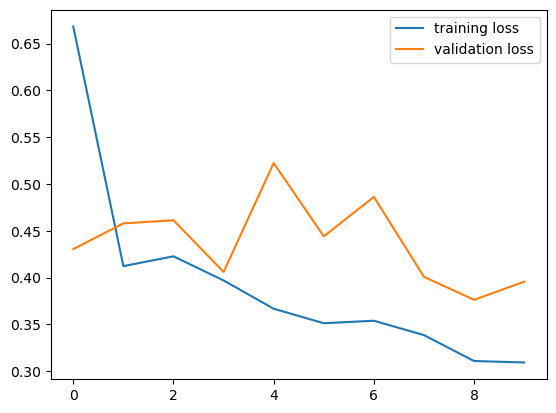

In [ ]:
# Loss And Validation Loss
plt.plot(hisy_vgg19.history["loss"], label = "training loss")
plt.plot(hisy_vgg19.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

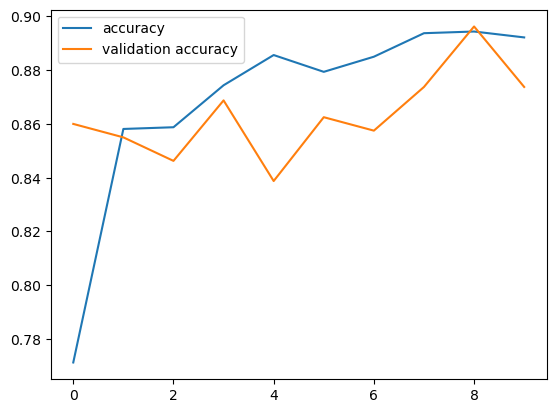

In [ ]:
# Accuracy And Validation Accuracy
plt.plot(hisy_vgg19.history["accuracy"], label = "accuracy")
plt.plot(hisy_vgg19.history["val_accuracy"], label = "validation accuracy")
plt.legend()
plt.show()